In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

corpus_name = "yfindata"
corpus = os.path.join("/content/drive/MyDrive/kaggle/", corpus_name)

df_main = pd.concat([pd.read_csv(os.path.join(corpus, f)) for f in ["SBIN.csv"] ])

df = df_main.dropna()
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d')

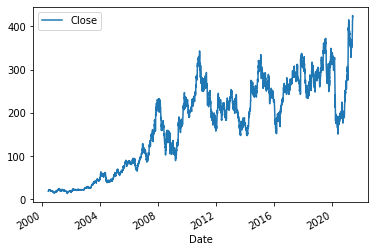

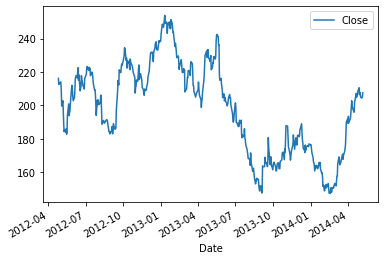

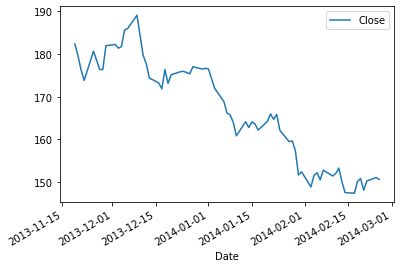

In [2]:
plot_cols = ['Close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][3000:3500]
plot_features.index = date_time[3000:3500]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][3385:3455]
plot_features.index = date_time[3385:3455]
_ = plot_features.plot(subplots=True)

In [7]:


# df = df.drop('Volume',1)
# df = df.drop('Adj Close',1)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_mean = df.mean()
df_std = df.std()
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

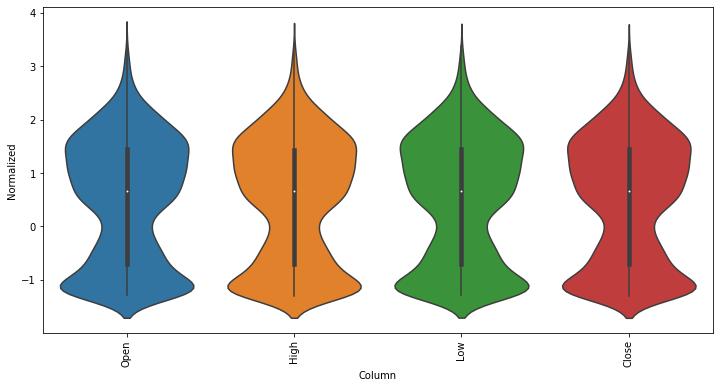

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()


train_mean.to_csv(os.path.join(corpus, "train_mean.csv"))
train_std.to_csv(os.path.join(corpus, "train_std.csv"))


train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset



@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [13]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 68
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60 61 62 63 64 65 66 67]
Label column name(s): None

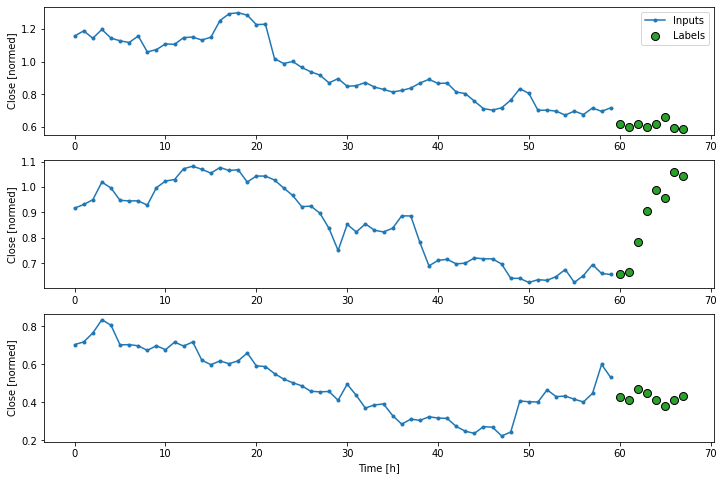

In [14]:
OUT_STEPS = 8
multi_window = WindowGenerator(input_width=60,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window


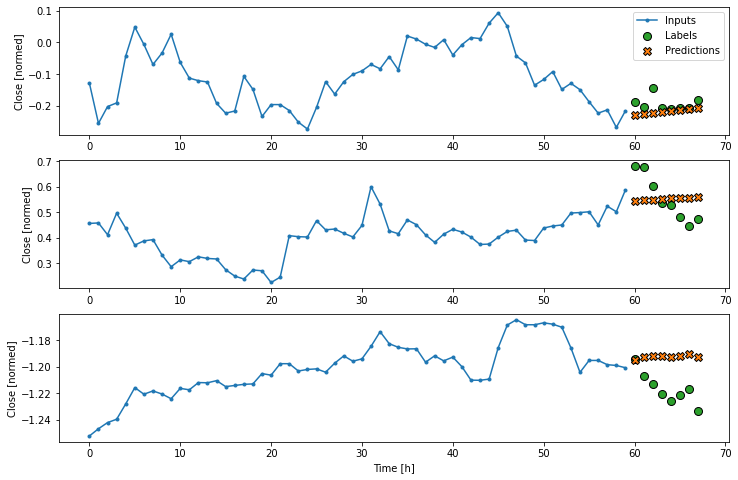

In [ ]:
#multi step input
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Total window size: 62
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60 61]
Label column name(s): None

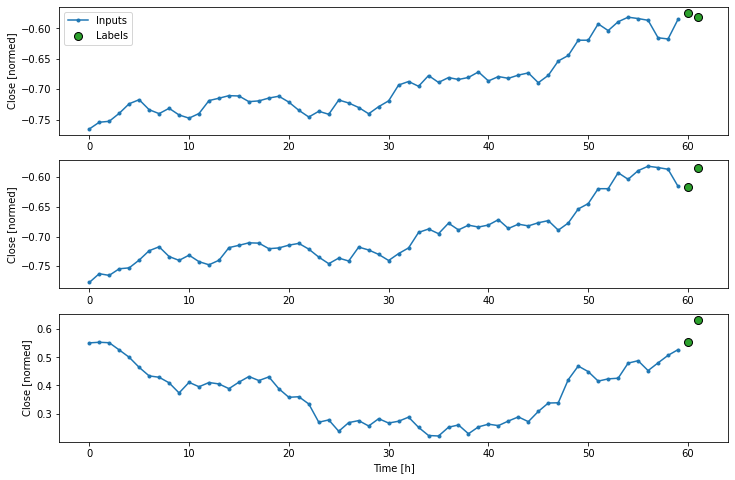

In [15]:
# Advanced: Autoregressive model

OUT_STEPS = 2
multi_window_reg = WindowGenerator(input_width=60,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window_reg.plot()
multi_window_reg

In [16]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [17]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [18]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [19]:
prediction, state = feedback_model.warmup(multi_window_reg.example[0])
prediction.shape

TensorShape([32, 4])

In [20]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [21]:
print('Output shape (batch, time, features): ', feedback_model(multi_window_reg.example[0]).shape)


Output shape (batch, time, features):  (32, 2, 4)


31/31 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_absolute_error: 0.0530


[0.006112539209425449, 0.053023725748062134]

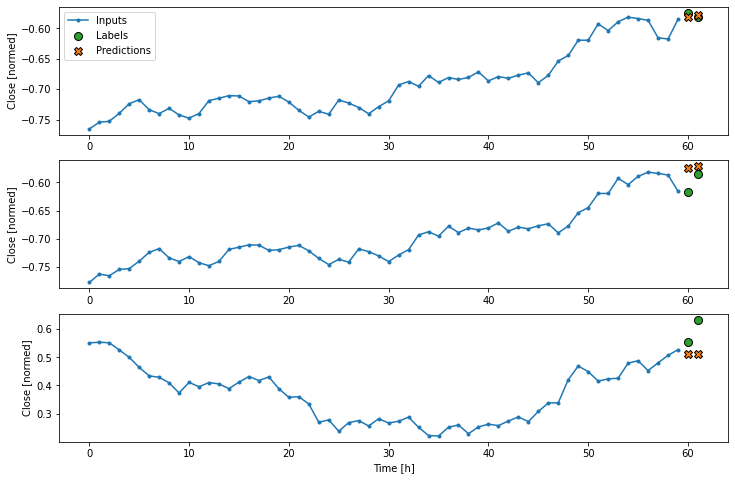

In [22]:
history = compile_and_fit(feedback_model, multi_window_reg)

IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
# multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window_reg.plot(feedback_model)

feedback_model.evaluate(multi_window_reg.val)

In [27]:
feedback_model.save(os.path.join(corpus,"saved_model/my_model_60_2"))


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/yfindata/saved_model/my_model_60_2/assets


In [28]:
new_model = tf.keras.models.load_model(os.path.join(corpus,"saved_model/my_model_60_2"))

# Check its architecture
new_model.summary()

Model: "feed_back"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell (LSTMCell)         multiple                  4736      
_________________________________________________________________
rnn (RNN)                    multiple                  4736      
_________________________________________________________________
dense (Dense)                multiple                  132       
Total params: 4,868
Trainable params: 4,868
Non-trainable params: 0
_________________________________________________________________


In [25]:
# start_index = 1200
# end_index = 1270
# test_sample = train_df[start_index:end_index]
# test_sample = test_sample.to_numpy().astype(np.float32)
# tt = np.expand_dims(test_sample, axis=0) 
# yhat = feedback_model.predict(tt, verbose=0)


# actual_sample_trun = train_df[start_index:end_index]
# actual_sample_trun = actual_sample_trun.to_numpy()
# actual_sample_trun = actual_sample_trun[:, 2]

# actual_sample = train_df[end_index-1:end_index+9]
# actual_sample = actual_sample.to_numpy()
# actual_sample = actual_sample[:, 2]

# print(yhat[0].shape)
# print(len(yhat[0]))
# # yhat_sample = yhat.to_numpy()
# yhat_sample = yhat[0][:, 2]


# # plt.subplot(3, 1, 1)
# plt.plot(np.arange(0,70),actual_sample_trun.dot(10), '-.', color="blue")
# plt.plot(np.arange(70,80),actual_sample.dot(10), '-.', color="red")
# plt.plot(np.arange(70,72),yhat_sample.dot(10), '-.', color="green")
  
# plt.xlabel("X-axis data")
# plt.ylabel("Y-axis data")
# plt.title('multiple plots')
# plt.show()


start_index = 3385
end_index = 3455
test_sample = train_df[start_index:end_index]
test_sample = test_sample.to_numpy().astype(np.float32)
tt = np.expand_dims(test_sample, axis=0) 

pred_arr = []
pred_arr_full = []
pred_arr_d = []


for i in range(12):
  yhat = feedback_model.predict(tt, verbose=0)
  tt = tt.reshape(70,4)
  tt = np.roll(tt, -2,axis=0)
  n1 = np.array([yhat[0][0]])
  n2 = np.array([yhat[0][1]])
  tt = np.insert (arr = tt, obj = len(tt), values = n1, axis = 0)
  tt = np.insert (arr = tt, obj = len(tt)-1, values = n2, axis = 0)
  tt = tt[0:70,:]
  tt = tt.reshape(1,70,4)
  pred_arr = np.append(pred_arr,yhat[0][0][2])
  pred_arr = np.append(pred_arr,yhat[0][1][2])
  pred_arr_full = np.append(pred_arr_full,yhat[0][0])
  pred_arr_full = np.append(pred_arr_full,yhat[0][1])

actual_sample_trun = train_df[start_index:end_index]
actual_sample_trun_np = actual_sample_trun.to_numpy()
actual_sample_trun = actual_sample_trun_np[:, 2]

actual_sample = train_df[end_index-1:end_index+23]
actual_sample_np = actual_sample.to_numpy()
actual_sample = actual_sample_np[:, 2]







(24, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


ValueError: ignored

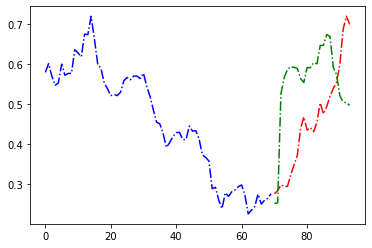

In [26]:
df_cpy = df
scal = StandardScaler()
X_t = scal.fit_transform(df_cpy)
pred_arr_full = pred_arr_full.reshape(24,4)
print(pred_arr_full.shape)
y = scal.inverse_transform(pred_arr_full)
x1 = scal.inverse_transform(actual_sample_trun_np)
x2 = scal.inverse_transform(actual_sample_np)

plt.plot(np.arange(0,70),actual_sample_trun, '-.', color="blue")
plt.plot(np.arange(70,94),actual_sample, '-.', color="red")
plt.plot(np.arange(70,94),pred_arr, '-.', color="green")
  


plt.subplot(1, 1, 1)


plt.plot(np.arange(0,70),x1.reshape(70), '-.', color="blue")
plt.plot(np.arange(70,94),x2.reshape(24), '-.', color="red")
plt.plot(np.arange(70,94),y.reshape(24), '-.', color="green")

plt.subplot(2, 1, 1)

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.title('multiple plots')
plt.show()



